In [2]:
from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import os

%matplotlib inline 

In [3]:
!git clone https://github.com/a18091986/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 3480, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 3480 (delta 0), reused 5 (delta 0), pack-reused 3475
Receiving objects: 100% (3480/3480), 118.25 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (6862/6862), done.


In [4]:
train_path = '/content/MachineLearning/Datasets/Cars_2/all'
batch_size = 25
img_w = 96
img_h = 54


In [5]:
#аугментация данных
data_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              zoom_range = 0.1,
                              horizontal_flip = True,
                              fill_mode = 'nearest',
                              validation_split = 0.1)

In [6]:
train_generator = data_gen.flow_from_directory(
    train_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training')


val_generator = data_gen.flow_from_directory(
    train_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 3086 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__176.png
/content/MachineLearning/Datasets/Cars_2/all/Renault/car__320.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__668.png
/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__419.png
/content/MachineLearning/Datasets/Cars_2/all/Renault/car__60.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__338.png
/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__967.png
/content/MachineLearning/Datasets/Cars_2/all/Renault/car__255.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__815.png


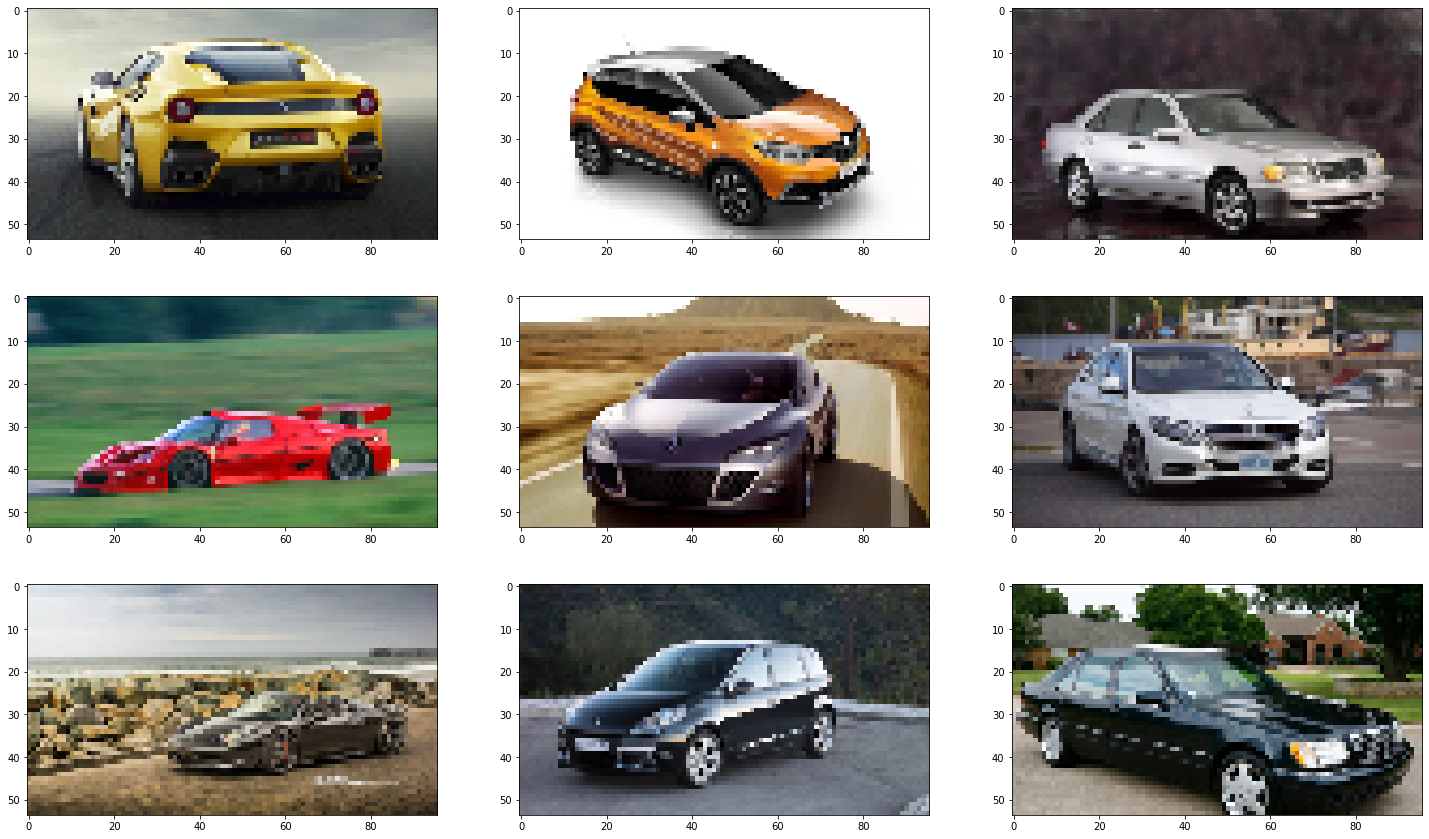

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(25, 15)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  for j in range(3):
    car_path = train_path + '/' + os.listdir(train_path)[j] + '/'
    img_path = car_path + random.choice(os.listdir(car_path))
    print(img_path)
    axs[i, j].imshow(image.load_img(img_path, target_size=(img_h, img_w))) #Отображение фотографии

plt.show() #Показываем изображения

In [12]:
def model_choose(pooling_layer_in, pooling_layer_out, n_epochs):
  #Создаем последовательную модель
  model = Sequential()
  #Первый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_w, img_h, 3)))
  #Второй сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_in)
  #Третий сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Четвертый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_in)
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Пятый сверточный слой
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  #Шестой сверточный слой
  model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_out)
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Слой преобразования двумерных данных в одномерные 
  model.add(Flatten())
  #Полносвязный слой
  model.add(Dense(2048, activation='relu'))
  #Полносвязный слой
  model.add(Dense(4096, activation='relu'))
  #Вызодной полносвязный слой
  model.add(Dense(len(train_generator.class_indices), activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

  history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=n_epochs,
    verbose=1
)
  
  plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

  return history.history['val_accuracy']

In [13]:
compare_dict = dict()
for pooling_layer_in in [(MaxPooling2D(pool_size = (2,2)), 1), (AveragePooling2D(pool_size = (2,2)), 2), (Conv2D(256, (2,2), padding = 'same', strides = (2,2), activation = 'relu'), 3),
                        (MaxPooling2D(pool_size = (3,3)), 4), (AveragePooling2D(pool_size = (3,3)), 5), (Conv2D(256, (3,3), padding = 'same', strides = (3,3), activation = 'relu'), 6)]:
  for pooling_layer_out in [(GlobalMaxPooling2D(), 1), (GlobalAveragePooling2D(), 2)]:
    print(f'Для комбинации {pooling_layer_in[1]}-{pooling_layer_out[1]}')
    result = model_choose(pooling_layer_in = pooling_layer_in[0], pooling_layer_out = pooling_layer_out[0], n_epochs = 10)
    compare_dict[f'{pooling_layer_in[1]}-{pooling_layer_out[1]}'] = result
    print(f'val_accuracy: {result[-1]}\n{"*"*100}')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


123/123 [==============================] - 36s 281ms/step - loss: 0.9785 - accuracy: 0.4812 - val_loss: 0.9578 - val_accuracy: 0.4862
Epoch 2/20
123/123 [==============================] - 34s 277ms/step - loss: 0.9259 - accuracy: 0.5270 - val_loss: 0.9410 - val_accuracy: 0.4892
Epoch 3/20
123/123 [==============================] - 34s 277ms/step - loss: 0.9062 - accuracy: 0.5456 - val_loss: 0.9284 - val_accuracy: 0.5138
Epoch 4/20
123/123 [==============================] - 34s 276ms/step - loss: 0.8996 - accuracy: 0.5547 - val_loss: 0.9106 - val_accuracy: 0.5138
Epoch 5/20
123/123 [==============================] - 34s 276ms/step - loss: 0.8989 - accuracy: 0.5642 - val_loss: 0.8891 - val_accuracy: 0.5600
Epoch 6/20
123/123 [==============================] - 34s 276ms/step - loss: 0.8772 - accuracy: 0.5684 - val_loss: 0.8984 - val_accuracy: 0.5508
Epoch 7/20
123/123 [==============================] - 34s 277ms/step - loss: 0.8652 - accuracy: 0.5776 - val_loss: 0.9388 - val_accuracy: 0.5

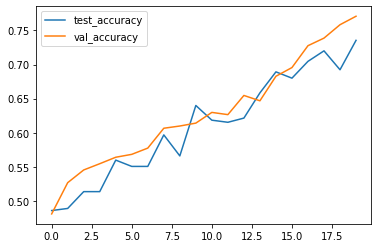

In [18]:
def model_choose(pooling_layer_in, pooling_layer_out, n_epochs):
  #Создаем последовательную модель
  model = Sequential()
  #Первый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_w, img_h, 3)))
  #Второй сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_in)
  #Третий сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Четвертый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_in)
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Пятый сверточный слой
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  #Шестой сверточный слой
  model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
  model.add(pooling_layer_out)
  #Слой регуляризации Dropout
  model.add(Dropout(0.2))
  #Слой преобразования двумерных данных в одномерные 
  model.add(Flatten())
  #Полносвязный слой
  model.add(Dense(2048, activation='relu'))
  #Полносвязный слой
  model.add(Dense(4096, activation='relu'))
  #Вызодной полносвязный слой
  model.add(Dense(len(train_generator.class_indices), activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

  history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=n_epochs,
    verbose=1
)
  
  # plt.plot(history.history['accuracy'], 
  #        label='Доля верных ответов на обучающем наборе')
  # plt.plot(history.history['val_accuracy'], 
  #         label='Доля верных ответов на проверочном наборе')
  # plt.xlabel('Эпоха обучения')
  # plt.ylabel('Доля верных ответов')
  # plt.legend()
  # plt.show()

  return history.history['val_accuracy'], history.history['accuracy'], model

test_accuracy, val_accuracy, model = model_choose(pooling_layer_in = MaxPooling2D(pool_size = (2,2)), pooling_layer_out = GlobalMaxPooling2D(), n_epochs = 20)

plt.plot(test_accuracy, label = 'test_accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.legend();

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


123/123 [==============================] - 36s 281ms/step - loss: 0.5100 - accuracy: 0.7886 - val_loss: 0.6644 - val_accuracy: 0.7446
Epoch 2/10
123/123 [==============================] - 34s 278ms/step - loss: 0.4825 - accuracy: 0.7952 - val_loss: 0.6588 - val_accuracy: 0.7415
Epoch 3/10
123/123 [==============================] - 34s 277ms/step - loss: 0.4383 - accuracy: 0.8259 - val_loss: 0.5656 - val_accuracy: 0.7815
Epoch 4/10
123/123 [==============================] - 34s 277ms/step - loss: 0.4225 - accuracy: 0.8308 - val_loss: 0.6101 - val_accuracy: 0.7508
Epoch 5/10
123/123 [==============================] - 34s 278ms/step - loss: 0.4090 - accuracy: 0.8324 - val_loss: 0.6059 - val_accuracy: 0.7785
Epoch 6/10
123/123 [==============================] - 34s 278ms/step - loss: 0.3844 - accuracy: 0.8445 - val_loss: 0.5391 - val_accuracy: 0.8092
Epoch 7/10
123/123 [==============================] - 34s 277ms/step - loss: 0.3839 - accuracy: 0.8393 - val_loss: 0.6914 - val_accuracy: 0.7

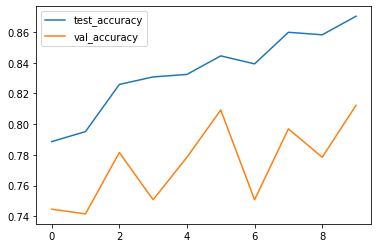

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

plt.plot(history.history['accuracy'], label = 'test_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


123/123 [==============================] - 55s 282ms/step - loss: 0.3065 - accuracy: 0.8739 - val_loss: 0.5577 - val_accuracy: 0.7969
Epoch 2/10
123/123 [==============================] - 34s 278ms/step - loss: 0.2741 - accuracy: 0.8912 - val_loss: 0.5679 - val_accuracy: 0.8031
Epoch 3/10
123/123 [==============================] - 34s 277ms/step - loss: 0.2533 - accuracy: 0.9020 - val_loss: 0.6154 - val_accuracy: 0.8185
Epoch 4/10
123/123 [==============================] - 34s 277ms/step - loss: 0.2552 - accuracy: 0.9004 - val_loss: 0.5313 - val_accuracy: 0.7969
Epoch 5/10
123/123 [==============================] - 34s 278ms/step - loss: 0.2548 - accuracy: 0.8964 - val_loss: 0.6336 - val_accuracy: 0.7631
Epoch 6/10
123/123 [==============================] - 34s 278ms/step - loss: 0.2479 - accuracy: 0.9043 - val_loss: 0.7537 - val_accuracy: 0.7723
Epoch 7/10
123/123 [==============================] - 34s 277ms/step - loss: 0.2139 - accuracy: 0.9128 - val_loss: 0.5453 - val_accuracy: 0.8

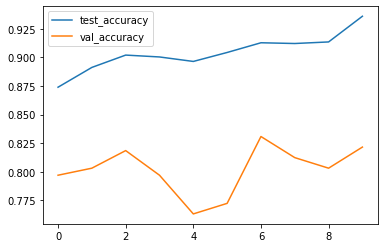

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

plt.plot(history.history['accuracy'], label = 'test_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
123/123 [==============================] - 36s 281ms/step - loss: 0.1263 - accuracy: 0.9539 - val_loss: 0.6086 - val_accuracy: 0.8215
Epoch 2/5
123/123 [==============================] - 34s 278ms/step - loss: 0.1179 - accuracy: 0.9615 - val_loss: 0.5954 - val_accuracy: 0.8246
Epoch 3/5
123/123 [==============================] - 34s 278ms/step - loss: 0.0908 - accuracy: 0.9680 - val_loss: 0.6279 - val_accuracy: 0.8462
Epoch 4/5
123/123 [==============================] - 34s 278ms/step - loss: 0.1049 - accuracy: 0.9592 - val_loss: 0.6166 - val_accuracy: 0.8431
Epoch 5/5
123/123 [==============================] - 34s 278ms/step - loss: 0.0841 - accuracy: 0.9706 - val_loss: 0.7137 - val_accuracy: 0.8338


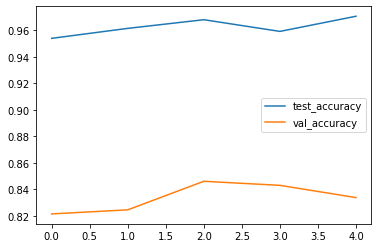

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=5,
    verbose=1
)

plt.plot(history.history['accuracy'], label = 'test_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();